In [1]:
!pip install ISLP -q
!pip install great_tables
!pip install graphviz
!pip install dowhy
!pip install lightgbm
!pip install econml

In [2]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import networkx as nx
from great_tables import GT as GT
from matplotlib.pyplot import subplots
from matplotlib import pyplot as plt
from statsmodels.api import OLS
from linearmodels import PanelOLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART

from copy import deepcopy
from sklearn.metrics import mean_absolute_percentage_error
import dowhy
from dowhy import CausalModel
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import graphviz

import seaborn as sns

In [3]:
df = pd.read_stata('./replication_sample.dta')
df_main = df[df['main_sample']==1].copy()

In [4]:
df_main['HHI_binary'] = df_main['HHI_hat'] >= 0.25
df_main = df_main.drop(columns='HHI_hat')
df_main.head(10)

,year,newhclust,HHI_bar,r_hat,num_words,num_char,long_tail,branded,numind,numberofresults,...,main_sample,ind_sample,own_branded,other_branded,negative_HHIchange,shiftmerge,sapientmerge,merklemerge,forsmanmerge,HHI_binary
61,2015,100302,0.250000,67775.184570,1.666667,12.666667,0.000000,0.000000,1,0.001094,...,1,1,0.000000,0.0,1.0,0,0,0,0,True
62,2016,100302,0.250000,166625.486694,1.714286,10.142858,0.142857,0.000000,1,0.141296,...,1,1,0.000000,0.0,1.0,0,0,0,0,True
63,2017,100302,0.500000,82004.383743,1.500000,9.000000,0.000000,0.000000,1,0.129090,...,1,1,0.000000,0.0,1.0,0,0,0,0,True
66,2016,100303,1.000000,26974.587952,1.800000,13.000000,0.000000,0.000000,1,0.046872,...,1,1,0.000000,0.0,0.0,0,0,0,0,True
69,2015,100304,1.000000,14800.044189,2.200000,14.000000,0.000000,0.200000,1,0.013334,...,1,1,0.200000,0.0,1.0,0,0,0,0,True
70,2016,100304,0.375000,27106.304688,2.000000,12.333333,0.000000,0.333333,1,0.023741,...,1,1,0.333333,0.0,1.0,0,0,0,0,True
71,2017,100304,0.555556,38390.056976,2.000000,13.000000,0.000000,0.250000,1,0.007591,...,1,1,0.250000,0.0,1.0,0,0,0,0,True
78,2016,100306,0.204615,13314.781036,1.600000,12.200000,0.000000,0.000000,1,0.000660,...,1,1,0.000000,0.0,1.0,0,0,0,0,False
79,2017,100306,0.500000,10846.478394,1.666667,10.000000,0.000000,0.000000,1,0.008772,...,1,1,0.000000,0.0,1.0,0,0,0,0,True
82,2017,100308,0.234568,12477.594727,2.000000,14.000000,0.000000,0.000000,1,0.001420,...,1,1,0.000000,0.0,1.0,0,0,0,0,False


In [5]:
df_main_pre = df_main[(df_main['timetoswitch'] < 0) | (df_main['evermerged'] == 0)].copy()
df_main_t0 = df_main[(df_main['year'] == 2015)].copy()

df_main = df_main.drop(columns=['allP_sample','main_sample','ind_sample','constant', 'logr_bar', 'r_hat', 'diffr_hat', 'HHI_bar', 'logcpc', 'logvol', 'lognum', 'timetoswitch', 'negative_HHIchange', 'shiftmerge', 'sapientmerge', 'merklemerge', 'forsmanmerge', 'evermerged', 'sim'])
df_main_pre = df_main_pre.drop(columns=['allP_sample','main_sample','ind_sample','constant', 'logr_bar', 'r_hat', 'diffr_hat', 'HHI_bar', 'logcpc', 'logvol', 'lognum', 'timetoswitch', 'negative_HHIchange', 'shiftmerge', 'sapientmerge', 'merklemerge', 'forsmanmerge', 'evermerged', 'sim'])
df_main_t0 = df_main_t0.drop(columns=['allP_sample','main_sample','ind_sample','constant', 'logr_bar', 'r_hat', 'diffr_hat', 'HHI_bar', 'logcpc', 'logvol', 'lognum', 'timetoswitch', 'negative_HHIchange', 'shiftmerge', 'sapientmerge', 'merklemerge', 'forsmanmerge', 'evermerged', 'sim'])

df_main_t0.head()

,year,newhclust,num_words,num_char,long_tail,branded,numind,numberofresults,logr_hat,cluster,own_branded,other_branded,HHI_binary
61,2015,100302,1.666667,12.666667,0.000000,0.0,1,0.001094,11.123951,1003,0.0,0.0,True
69,2015,100304,2.200000,14.000000,0.000000,0.2,1,0.013334,9.602386,1003,0.2,0.0,True
97,2015,100314,2.000000,9.000000,0.000000,0.0,1,0.002960,9.635104,1003,0.0,0.0,True
168,2015,100801,2.405714,15.222857,0.160000,0.0,1,0.014277,10.158752,1008,0.0,0.0,True
176,2015,100803,2.888889,17.888889,0.333333,0.0,1,0.082272,9.394144,1008,0.0,0.0,True


## Playing with Data Structure

In [7]:
# Use .loc to avoid the warning
#df_main.loc[:, 'merged'] = 0  # This ensures 'merged' is added directly to df_main

# Set 'merged' to 1 where 'timetoswitch' is greater than 0
#df_main.loc[df_main['timetoswitch'] > 0, 'merged'] = 1

# Check the result
#df_main['merged'].describe()
#df_main['evermerged'].describe()


In [8]:
#wide_vars = ['newhclust','HHI_hat','logr_hat','long_tail','branded','cluster','year', 'timetoswitch', 'merged', 'evermerged']
#index_vars = ['newhclust','cluster']
#value_vars = ['HHI_hat','logr_hat','long_tail','branded', 'timetoswitch', 'merged', 'evermerged']

#df_wide = df_main[wide_vars]
#df_wide.shape

#df_wide['idx'] = df_wide.groupby('newhclust').cumcount()+1

#df_wide = df_main.pivot_table(index=index_vars, columns='year', 
                    #values=value_vars, aggfunc='first')

#df_wide = df_wide.sort_index(axis=1, level=1)
#df_wide.columns = [f'{x}_{y}' for x,y in df_wide.columns]
#df_wide = df_wide.reset_index()

#df_wide.head()

# Matching

In [10]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

In [11]:
# Construct the graph (the graph is constant for all iterations)
#nodes = [
#    ('logr_hat', 'log(Revenue)'),
#    ('HHI_binary', 'HHI'), 
#    ('sim', 'M&A'),
#    ('long_tail', 'Long-Tailed'),
#    ('branded', 'Branded'),
#    ('cluster', 'Thematic Cluster'),
#    ('year', 'Year')
#]

nodes = [
    'logr_hat',
    'HHI_binary',
    'sim',
    'long_tail',
    'branded',
    'cluster',
    'year'
]
     
#labels = ['log(Revenue)', 'HHI', 'M&A', 'Long-Tailed Keywords', 'Branded Bidding', 'Thematic Cluster', 'Year']
edges = [
    ('HHI_binary', 'logr_hat'),
    ('long_tail', 'logr_hat'),
    ('branded', 'logr_hat'),
    ('cluster', 'logr_hat'),
    ('year', 'logr_hat'),
    ('long_tail', 'HHI_binary'),
    ('branded', 'HHI_binary'),
    ('cluster', 'HHI_binary'),
    ('year', 'HHI_binary'),
    ('sim', 'HHI_binary'),
    ('year', 'sim'),
    ('cluster', 'sim')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'

In [12]:
# Instantiate the CausalModel 
model = CausalModel(
    data=df_main,
    treatment='HHI_binary',
    outcome='logr_hat',
    graph=gml_string
)

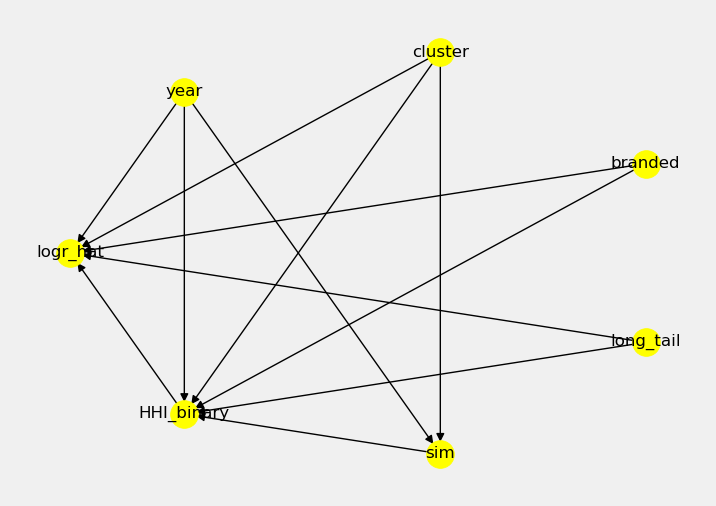

In [13]:
model.view_model()

In [14]:
# Get the estimand
estimand = model.identify_effect()

print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                  
─────────────(E[logr_hat|cluster,long_tail,year,branded])
d[HHI_binary]                                            
Estimand assumption 1, Unconfoundedness: If U→{HHI_binary} and U→logr_hat then P(logr_hat|HHI_binary,cluster,long_tail,year,branded,U) = P(logr_hat|HHI_binary,cluster,long_tail,year,branded)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [15]:
# Get estimate (Matching)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.distance_matching',
    target_units='ate',
    method_params={'distance_metric': 'minkowski', 'p': 2})

distance_matching


In [16]:
estimate.value

In [17]:
estimate = model.estimate_effect(identified_estimand=estimand,
                                 method_name="backdoor.propensity_score_matching",
                                 target_units="ate")

propensity_score_matching


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
estimate.value

In [19]:
estimate = model.estimate_effect(identified_estimand=estimand,
                                 method_name="backdoor.propensity_score_weighting",
                                 target_units = "ate",
                                 method_params={"weighting_scheme":"ips_weight"})

propensity_score_weighting


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
estimate.value

In [21]:
#refutation = model.refute_estimate(
    #estimand=estimand, 
    #estimate=estimate,
    #method_name='random_common_cause')

In [22]:
#print(refutation)

In [23]:
# Get estimate (Doubly robust)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dr.LinearDRLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'model_propensity': LogisticRegression(),
            'model_regression': LGBMRegressor(n_estimators=1000, max_depth=10)
        },
        'fit_params': {}
    })

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 26238, number of used features: 5
[LightGBM] [Info] Start training from score 10.408713
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 26238, number of used features: 5
[LightGBM] [Info] Start training from score 10.415948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [24]:
estimate.cate_estimates.mean()

In [39]:
# Get estimate (Doubly robust)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dr.DRLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'model_propensity': LogisticRegression(),
            'model_regression': LGBMRegressor(n_estimators=1000, max_depth=10),
            'model_final': LGBMRegressor(n_estimators=500, max_depth=10),
        },
        'fit_params': {}
    })

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 26238, number of used features: 5
[LightGBM] [Info] Start training from score 10.404837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 26238, number of used features: 5
[LightGBM] [Info] Start training from score 10.419825


ValueError: Expected 2D array, got scalar array instead:
array=None.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [29]:
estimate.cate_estimates.mean()

# IPW

## Propensity Score Estimation (ALL OBSERVATIONS)

In [ ]:
##Incorporating fixed effects into PS logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Assuming `data` is a DataFrame with 'response', 'predictor1', 'predictor2', 'year', and 'cluster' columns
X = df_main[['num_words', 'num_char', 'long_tail', 'branded', 'numberofresults', 'own_branded', 'other_branded', 'year']]  # predictors, including fixed effect variables
T = df_main['HHI_binary']  # the response variable for logistic regression

# Pipeline to encode the two fixed effect variables and fit logistic regression
pipeline = Pipeline(steps=[
    # Step 1: Apply one-hot encoding to the fixed effect variables (year and cluster)
    ('onehot', ColumnTransformer(
        transformers=[
            ('year_fe', OneHotEncoder(drop='first'), ['year']),        # Encode 'year' fixed effect
            #('cluster_fe', OneHotEncoder(drop='first'), ['cluster'])   # Encode 'cluster' fixed effect
        ],
        remainder='passthrough')),  # leaves other columns (predictors) untouched

    # Step 2: Fit logistic regression on the transformed data
    ('logit', LogisticRegression(max_iter=10000))
])

# Fit the pipeline to the data
logistic = pipeline.fit(X, T)

In [ ]:
from sklearn.linear_model import LogisticRegression

df_main['HHI_binary'] = df_main['HHI_binary'].astype(int)

T = 'HHI_binary'
Y = 'logr_hat'
X = df_main.columns.drop(['newhclust', 'numind', 'cluster', T, Y])

ps_model = LogisticRegression(C=1e6).fit(df_main[X], df_main[T])
#ps_model = logistic

data_ps = df_main.assign(propensity_score=ps_model.predict_proba(df_main[X])[:, 1])

#data_ps[["HHI_binary", "logr_hat", "propensity_score"]].head()
data_ps.head(10)

In [ ]:
weight_t = 1/data_ps.query("HHI_binary==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("HHI_binary==0")["propensity_score"])

In [ ]:
sns.distplot(data_ps.query("HHI_binary==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("HHI_binary==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

In [ ]:
weight = ((data_ps["HHI_binary"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("HHI_binary==1")["logr_hat"]*weight_t) / len(data_ps)
y0 = sum(data_ps.query("HHI_binary==0")["logr_hat"]*weight_nt) / len(data_ps)

ate = np.mean(weight * data_ps["logr_hat"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

## Propensity Score Estimation (Pre-treatment)

In [ ]:
##Incorporating fixed effects into PS logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Assuming `data` is a DataFrame with 'response', 'predictor1', 'predictor2', 'year', and 'cluster' columns
X = df_main_pre[['num_words', 'num_char', 'long_tail', 'branded', 'numberofresults', 'own_branded', 'other_branded', 'year']]  # predictors, including fixed effect variables

T = df_main_pre['HHI_binary']  # the response variable for logistic regression

# Pipeline to encode the two fixed effect variables and fit logistic regression
pipeline = Pipeline(steps=[
    # Step 1: Apply one-hot encoding to the fixed effect variables (year and cluster)
    ('onehot', ColumnTransformer(
        transformers=[
            ('year_fe', OneHotEncoder(drop='first'), ['year']),        # Encode 'year' fixed effect
            #('cluster_fe', OneHotEncoder(drop='first'), ['cluster'])   # Encode 'cluster' fixed effect
        ],
        remainder='passthrough')),  # leaves other columns (predictors) untouched

    # Step 2: Fit logistic regression on the transformed data
    ('logit', LogisticRegression(max_iter=10000))
])

# Fit the pipeline to the data
logistic = pipeline.fit(X, T)

In [ ]:
from sklearn.linear_model import LogisticRegression

df_main_pre['HHI_binary'] = df_main_pre['HHI_binary'].astype(int)

T = 'HHI_binary'
Y = 'logr_hat'
X = df_main_pre.columns.drop(['newhclust', 'cluster', 'numind', T, Y])

ps_model = LogisticRegression(C=1e6).fit(df_main_pre[X], df_main_pre[T])
#ps_model = logistic

data_ps = df_main_pre.assign(propensity_score=ps_model.predict_proba(df_main_pre[X])[:, 1])

#data_ps[["HHI_binary", "logr_hat", "propensity_score"]].head()
data_ps.head(10)

In [ ]:
weight_t = 1/data_ps.query("HHI_binary==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("HHI_binary==0")["propensity_score"])

In [ ]:
sns.distplot(data_ps.query("HHI_binary==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("HHI_binary==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

In [ ]:
weight = ((data_ps["HHI_binary"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("HHI_binary==1")["logr_hat"]*weight_t) / len(data_ps)
y0 = sum(data_ps.query("HHI_binary==0")["logr_hat"]*weight_nt) / len(data_ps)

ate = np.mean(weight * data_ps["logr_hat"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

## Propensity Score Estimation (t=0)(2015)

In [ ]:
##Incorporating fixed effects into PS logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Assuming `data` is a DataFrame with 'response', 'predictor1', 'predictor2', 'year', and 'cluster' columns
X = df_main_t0[['num_words', 'num_char', 'long_tail', 'branded', 'numind', 'numberofresults', 'own_branded', 'other_branded', 'year', 'cluster']]  # predictors, including fixed effect variables
T = df_main_t0['HHI_binary']  # the response variable for logistic regression

# Pipeline to encode the two fixed effect variables and fit logistic regression
pipeline = Pipeline(steps=[
    # Step 1: Apply one-hot encoding to the fixed effect variables (year and cluster)
    ('onehot', ColumnTransformer(
        transformers=[  
            ('cluster_fe', OneHotEncoder(drop='first'), ['cluster'])   # Encode 'cluster' fixed effect
        ],
        remainder='passthrough')),  # leaves other columns (predictors) untouched

    # Step 2: Fit logistic regression on the transformed data
    ('logit', LogisticRegression(max_iter=10000))
])

# Fit the pipeline to the data
logistic = pipeline.fit(X, T)

In [ ]:
from sklearn.linear_model import LogisticRegression

df_main_t0['HHI_binary'] = df_main_t0['HHI_binary'].astype(int)

T = 'HHI_binary'
Y = 'logr_hat'
X = df_main_t0.columns.drop(['newhclust', 'cluster', 'numind', T, Y])

ps_model = LogisticRegression(C=1e6).fit(df_main_t0[X], df_main_t0[T])
#ps_model = logistic

data_ps = df_main_t0.assign(propensity_score=ps_model.predict_proba(df_main_t0[X])[:, 1])

#data_ps[["HHI_binary", "logr_hat", "propensity_score"]].head()
data_ps.head(10)

In [ ]:
weight_t = 1/data_ps.query("HHI_binary==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("HHI_binary==0")["propensity_score"])

In [ ]:
sns.distplot(data_ps.query("HHI_binary==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("HHI_binary==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

In [ ]:
weight = ((data_ps["HHI_binary"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("HHI_binary==1")["logr_hat"]*weight_t) / len(data_ps)
y0 = sum(data_ps.query("HHI_binary==0")["logr_hat"]*weight_nt) / len(data_ps)

ate = np.mean(weight * data_ps["logr_hat"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

# Meta-Learners - Binary

In [ ]:
from toolz import curry

@curry
def elast(data, y, t):
    return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
            np.sum((data[t] - data[t].mean())**2))

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

In [ ]:
df_main.head()
X = df_main.drop(columns=['logr_hat', 'newhclust', 'HHI_binary'])
X_cols = print(list(X.columns))

y = "logr_hat"
T = "HHI_binary"
X = ['year', 'num_words', 'num_char', 'long_tail', 'branded', 'numind', 'numberofresults', 'cluster', 'own_branded', 'other_branded']

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_main, test_size=0.2, random_state=42)

## S-Learner

In [ ]:
from lightgbm import LGBMRegressor

np.random.seed(123)
s_learner = LGBMRegressor(max_depth=3, min_child_samples=30)
s_learner.fit(train[X+[T]], train[y]);

In [ ]:
s_learner_cate_train = (s_learner.predict(train[X].assign(**{T: 1})) -
                        s_learner.predict(train[X].assign(**{T: 0})))

s_learner_cate_test = test.assign(
    cate=(s_learner.predict(test[X].assign(**{T: 1})) - # predict under treatment
          s_learner.predict(test[X].assign(**{T: 0}))) # predict under control
)

In [ ]:
gain_curve_test = cumulative_gain(s_learner_cate_test, "cate", y="logr_hat", t="HHI_binary")
gain_curve_train = cumulative_gain(train.assign(cate=s_learner_cate_train), "cate", y="logr_hat", t="HHI_binary")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "logr_hat", "HHI_binary")], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("S-Learner");
#45 degree line is baseline, as good as random model. Maybe overfitting a little because Train is performing better than Test, 
#which is closer to the baseline.

## T-Learner

In [ ]:
np.random.seed(123)

m0 = LGBMRegressor(max_depth=2, min_child_samples=60)
m1 = LGBMRegressor(max_depth=2, min_child_samples=60)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# estimate the CATE
t_learner_cate_train = m1.predict(train[X]) - m0.predict(train[X])
t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X]))

In [ ]:
gain_curve_test = cumulative_gain(t_learner_cate_test, "cate", y="logr_hat", t="HHI_binary")
gain_curve_train = cumulative_gain(train.assign(cate=t_learner_cate_train), "cate", y="logr_hat", t="HHI_binary")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "logr_hat", "HHI_binary")], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("T-Learner");

## X-Learner

In [ ]:
from sklearn.linear_model import LogisticRegression

np.random.seed(123)

# first stage models
m0 = LGBMRegressor(max_depth=2, min_child_samples=30)
m1 = LGBMRegressor(max_depth=2, min_child_samples=30)

# propensity score model
g = LogisticRegression(solver="lbfgs", penalty=None) 

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])
                       
g.fit(train[X], train[T]);

In [ ]:
d_train = np.where(train[T]==0,
                   m1.predict(train[X]) - train[y],
                   train[y] - m0.predict(train[X]))

# second stage
mx0 = LGBMRegressor(max_depth=2, min_child_samples=30)
mx1 = LGBMRegressor(max_depth=2, min_child_samples=30)

mx0.fit(train.query(f"{T}==0")[X], d_train[train[T]==0])
mx1.fit(train.query(f"{T}==1")[X], d_train[train[T]==1]);

In [ ]:
def ps_predict(df, t): 
    return g.predict_proba(df[X])[:, t]
    
x_cate_train = (ps_predict(train,1)*mx0.predict(train[X]) +
                ps_predict(train,0)*mx1.predict(train[X]))

x_cate_test = test.assign(cate=(ps_predict(test,1)*mx0.predict(test[X]) +
                                ps_predict(test,0)*mx1.predict(test[X])))

In [ ]:
gain_curve_test = cumulative_gain(x_cate_test, "cate", y="logr_hat", t="HHI_binary")
gain_curve_train = cumulative_gain(train.assign(cate=x_cate_train), "cate", y="logr_hat", t="HHI_binary")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "logr_hat", "HHI_binary")], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("X-Learner");

# Meta-Learners - Other

## S-Learner

In [ ]:
df = pd.read_stata('./replication_sample.dta')
df_main = df[df['main_sample']==1].copy()
df_main = df_main.drop(columns=['allP_sample','main_sample','ind_sample','constant', 'logr_bar', 'r_hat', 'diffr_hat', 'HHI_bar', 'logcpc', 'logvol', 'lognum', 'timetoswitch', 'negative_HHIchange', 'shiftmerge', 'sapientmerge', 'merklemerge', 'forsmanmerge', 'evermerged'])

y = "logr_hat"
T = "HHI_binary"
X = ['year', 'num_words', 'num_char', 'long_tail', 'branded', 'numind', 'numberofresults', 'cluster', 'own_branded', 'other_branded']

In [ ]:
np.random.seed(123)

m0 = LGBMRegressor(max_depth=2, min_child_samples=60)
m1 = LGBMRegressor(max_depth=2, min_child_samples=60)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# estimate the CATE
t_learner_cate_train = m1.predict(train[X]) - m0.predict(train[X])
t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X]))

In [ ]:
from lightgbm import LGBMRegressor

np.random.seed(123)
s_learner = LGBMRegressor(max_depth=3, min_child_samples=30)
s_learner.fit(train[X+[T]], train[y]);

In [ ]:
s_learner_cate_train = (s_learner.predict(train[X].assign(**{T: 1})) -
                        s_learner.predict(train[X].assign(**{T: 0})))

s_learner_cate_test = test.assign(
    cate=(s_learner.predict(test[X].assign(**{T: 1})) - # predict under treatment
          s_learner.predict(test[X].assign(**{T: 0}))) # predict under control
)

In [ ]:
gain_curve_test = cumulative_gain(s_learner_cate_test, "cate", y="logr_hat", t="HHI_hat")
gain_curve_train = cumulative_gain(train.assign(cate=s_learner_cate_train), "cate", y="logr_hat", t="HHI_hat")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "logr_hat", "HHI_hat")], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("S-Learner");
#45 degree line is baseline, as good as random model. Maybe overfitting a little because Train is performing better than Test, 
#which is closer to the baseline.

# T-Learner

In [ ]:
np.random.seed(123)

m0 = LGBMRegressor(max_depth=2, min_child_samples=60)
m1 = LGBMRegressor(max_depth=2, min_child_samples=60)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# estimate the CATE
t_learner_cate_train = m1.predict(train[X]) - m0.predict(train[X])
t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X]))

In [ ]:
print(elast(test, "logr_hat", "sim"))

# DR-Learner

In [ ]:
! pip install econml -q

df_main.head()

In [ ]:
def doubly_robust(df, X, T, Y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LGBMRegressor(n_estimators=1000, max_depth=10).fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LGBMRegressor(n_estimators=1000, max_depth=10).fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [ ]:
Y = 'logr_hat'
T = 'HHI_binary'
X = df_main.columns.drop(['newhclust','cluster', 'numind', T, Y])
#X = df_main.drop(columns=['newhclust','logr_hat','HHI_binary'])

doubly_robust(df_main, X, T, Y)
#print(Y)

In [ ]:
from joblib import Parallel, delayed # for parallel processing

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 100
ates = Parallel(n_jobs=4)(delayed(doubly_robust)(df_main.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

In [ ]:
print(f"ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

In [ ]:
from sklearn.linear_model import LassoCV
from econml.dr import LinearDRLearner
from sklearn.dummy import DummyClassifier

y = df_main['logr_hat']
T = df_main['HHI_binary']
X = df_main.drop(columns=['newhclust','logr_hat','HHI_binary'])

# One can replace model_y and model_t with any scikit-learn regressor and classifier correspondingly
# as long as it accepts the sample_weight keyword argument at fit time.
est = LinearDRLearner(model_regression=LGBMRegressor(n_estimators=1000, max_depth=10),
                      model_propensity=LogisticRegression(max_iter=1000))
est.fit(y, T, X=X, W=None)

In [ ]:
# Getting the confidence intervals of the coefficients of the CATE model; USE IN PROJECT - effect of variables on treatment effect
# together with the corresponding feature names.
feat_names = est.cate_feature_names(list(X.columns))
point = est.coef_(T=1)
lower, upper = np.array(est.coef__interval(T=1))
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,1)
    x = np.arange(len(point))
    plt.errorbar(x, point, yerr, fmt='o')
    ax.set_xticks(x)
    ax.set_xticklabels(feat_names, rotation='vertical', fontsize=18)
    ax.set_ylabel('coef')
    plt.show()

In [ ]:
est.summary(T=1, feature_names=X.columns)

In [ ]:
from econml.sklearn_extensions.linear_model import WeightedLassoCV
from econml.dr import LinearDRLearner
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import PolynomialFeatures

# One can replace model_y and model_t with any scikit-learn regressor and classifier correspondingly
# as long as it accepts the sample_weight keyword argument at fit time.
est = LinearDRLearner(model_regression=WeightedLassoCV(cv=3),
                      model_propensity=LogisticRegression(),
                      featurizer=PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
#Polynomial Features: Interaction_only; no squared variables, just A*B, A*C, etc.
est.fit(y, T, X=X, W=None)

In [ ]:
# Getting the confidence intervals of the coefficients of the CATE model
# together with the corresponding feature names.
feat_names = est.cate_feature_names(X.columns)
point = est.coef_(T=1)
lower, upper = np.array(est.coef__interval(T=1, alpha=0.05))
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,1)
    x = np.arange(len(point))
    plt.errorbar(x, point, yerr, fmt='o')
    ax.set_xticks(x)
    ax.set_xticklabels(feat_names, rotation='vertical', fontsize=18)
    ax.set_ylabel('coef')
    plt.show()

In [ ]:
from econml.dr import ForestDRLearner
from sklearn.ensemble import GradientBoostingRegressor

#dont use this propesnity model, this is purposely a mis-specificaiton to show double robustness

est = ForestDRLearner(model_regression=GradientBoostingRegressor(),
                      model_propensity=DummyClassifier(strategy='prior'),
                      cv=5,
                      n_estimators=1000,
                      min_samples_leaf=10,#min 10 samples
                      verbose=0, min_weight_fraction_leaf=.01) #min 1% of the total weight of all samples.
est.fit(y, T, X=X)

In [ ]:
est.feature_importances_(T=1)

In [ ]:
# Getting the inference of the CATE at different X vector values
est.effect_inference(X).summary_frame()